# Half Adder Circuit Simulation
![image](circuit.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

State vector:
 [ 0.35355339-0.35355339j  0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.35355339+0.35355339j  0.        +0.j          0.        +0.j
  0.        +0.j         -0.35355339+0.35355339j  0.        +0.j
  0.        +0.j         -0.35355339-0.35355339j  0.        +0.j
  0.        +0.j        ]
Distribution:
 [0.25 0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.25 0.   0.   0.25
 0.   0.  ]
Measurements:
 {'0000': 2, '0110': 1, '1010': 1, '1101': 1}


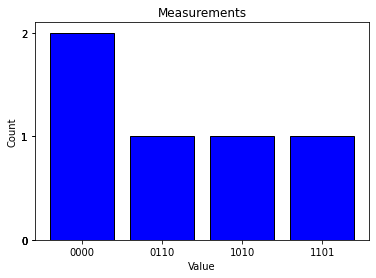

In [23]:
q = QuantumCircuit(4)
q.x(0)
q.h(0)
q.h(1)
q.rz(np.pi/2, 1)
q.cx(0, 2)
q.cx(1, 2)
q.ccx(0, 1, 3)
print("State vector:\n", q.get_statevector())
print("Measurements:\n", q.measure(5))
q.draw_measures()

# Class QuantumCircuit

In [21]:
# Class QuantumCircuit
class QuantumCircuit:
    def __init__(self, qubits):
        if qubits < 1:
            raise Exception("qubits should be more than zero")
        self.qubits = qubits
        self.measures = {}
        
        # Init state vector
        self.state_vector = np.zeros((2**qubits), dtype=complex)
        # Start from state "0000"
        self.state_vector[0] = 1.+0.j
        
        # Init NOT gate matrix
        X = np.array([[0, 1], [1, 0]], dtype=complex) # x(0)
        I = np.eye(2**(qubits - 1))
        self.XI = np.kron(X, I)
        
        # Init H gate matrix
        H = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2) # h(0)
        I = np.eye(2**(qubits - 1))
        self.HI = np.kron(H, I)
        
        # Init CNOT gate matrix
        if qubits >= 2:
            CX = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]], dtype=complex) # cx(0,1)
            I = np.eye(2**(qubits - 2))
            self.CXI = np.kron(CX, I)

        # Init Toffoli gate matrix
        if qubits >= 3:
            CCX = np.array(
                  [[1, 0, 0, 0, 0, 0, 0, 0],
                   [0, 1, 0, 0, 0, 0, 0, 0],
                   [0, 0, 1, 0, 0, 0, 0, 0],
                   [0, 0, 0, 1, 0, 0, 0, 0],
                   [0, 0, 0, 0, 1, 0, 0, 0],
                   [0, 0, 0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 1],
                   [0, 0, 0, 0, 0, 0, 1, 0]], dtype=complex) # ccx(0,1,2)
            I = np.eye(2**(qubits - 3))
            self.CCXI = np.kron(CCX, I)

    def get_statevector(self):
        return self.state_vector

    def x(self, q0):
        if not self.__check_param(q0):
            raise Exception("wrong parameter")
        perm = self.__get_perm(q0)
        G = self.__reorder_gate(self.XI, perm)
        self.state_vector = np.matmul(G, self.state_vector)

    def h(self, q0):
        if not self.__check_param(q0):
            raise Exception("wrong parameter")
        perm = self.__get_perm(q0)
        G = self.__reorder_gate(self.HI, perm)
        self.state_vector = np.matmul(G, self.state_vector)

    def rz(self, phi, q0):
        
        if not self.__check_param(q0):
            raise Exception("wrong parameter")
            
        # Init RZ gate matrix
        RZ = np.array([[np.exp(-0.5j*phi), 0], [0, np.exp(0.5j*phi)]], dtype=complex) # rz(phi, 0)
        #print("\nRZ gate base matrix:\n", RZ)
        
        # Adjust RZ gate matrix for circuit size
        I = np.eye(2**(self.qubits - 1))
        RZI = np.kron(RZ, I)
        #print("\nRZ gate matrix for quibit 0:\n", RZI)
        
        # reorder to qbit q0
        perm = self.__get_perm(q0)
        G = self.__reorder_gate(RZI, perm)
        #print("\nRZ gate matrix for quibit {}:\n".format(q0), G)
        
        # calculate new state vector
        self.state_vector = np.matmul(G, self.state_vector)        
        
    def cx(self, q0, q1):
        if not self.__check_param(q0, q1):
            raise Exception("wrong parameter")
        perm = self.__get_perm(q0, q1)
        G = self.__reorder_gate(self.CXI, perm)
        self.state_vector = np.matmul(G, self.state_vector)        

    def ccx(self, q0, q1, q2):
        if not self.__check_param(q0, q1, q2):
            raise Exception("wrong parameter")
        perm = self.__get_perm(q0, q1, q2)
        G = self.__reorder_gate(self.CCXI, perm)
        self.state_vector = np.matmul(G, self.state_vector)   
    
    def measure(self, shots):
        
        # calculate probability distribution
        distribution = abs(self.state_vector)**2
        print("Distribution:\n", distribution)
        
        # perform measures with a random sample function
        self.measures = {}
        for i in range(shots):
            sample = np.random.choice(len(distribution), p=distribution)
            key = f"{sample:0{self.qubits}b}" # single measurement as a bitstring
            if key in self.measures:
                self.measures[key] += 1
            else:
                self.measures[key] = 1
                
        # sort the dictionary
        self.measures = dict(sorted(self.measures.items()))
        return self.measures
    
    def draw_measures(self):
        # Extract labels and values
        labels = list(self.measures.keys())
        values = list(self.measures.values())

        # Plotting the histogram
        plt.bar(labels, values, color='blue', edgecolor='black')

        # Adding labels and title
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Measurements')
        
        # Format y-axis values to integers
        plt.yticks([int(value) for value in plt.yticks()[0]])

        # Display the plot
        plt.show()
    
    def __check_param(self, *args):
        for i in range(len(args)):
            if not args[i] in range(0, self.qubits):
                return False
        return (len(args) == len(set(args)))
    
    def __get_perm(self, *args):
        perm = np.full(self.qubits, -1, dtype=int)
        for i in range(len(args)):
            perm[args[i]] = i
        value = len(args)
        for i in range(len(perm)):
            if perm[i] == -1:
                perm[i] = value
                value += 1        
        return perm
            
    def __reorder_gate(self, G, perm):
        """
        Adapt gate G to an ordering of the qubits as specified in perm.
        Example, given G = np.kron(np.kron(A, B), C):
        reorder_gate(G, [1, 2, 0]) == np.kron(np.kron(B, C), A)
        """
        perm = list(perm)
        # number of qubits
        n = len(perm)
        # reorder both input and output dimensions
        perm2 = perm + [n + i for i in perm]
        return np.reshape(np.transpose(np.reshape(G, 2*n*[2]), perm2), (2**n, 2**n))